In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_DNN"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


<!-- <span style="color:#fff; font-family: 'Bebas Neue'; font-size: 1.2em;">Number of iterations</span> -->

In [2]:
from tensorflow import keras

## Vanishing/Exploding Gradients Problem

As we discussed in Chapter 10, the backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient along the way. Once the algorithm has computed the gradient of the cost function with regard to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step.

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. We call this the **`vanishing gradients`** problem. In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the **`exploding gradients`** problem, which surfaces in recurrent neural networks (see Chapter 15). More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds.

***This unfortunate behavior was empirically observed long ago, and it was one of the reasons deep neural networks were mostly abandoned in the early 2000s. It wasn’t clear what caused the gradients to be so unstable when training a DNN, but some light was shed in a 2010 paper by Xavier Glorot and Yoshua Bengio.1 The authors found a few suspects, including the combination of the popular logistic sigmoid activation function and the weight initialization technique that was most popular at the time (i.e., a normal distribution with a mean of 0 and a standard deviation of 1). In short, they showed that with this activation function and this initialization scheme, the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This saturation is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the logistic function in deep networks).***

***Looking at the logistic activation function (see Figure 11-1), you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.***

In [3]:
def logit(z):
    return 1/(1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


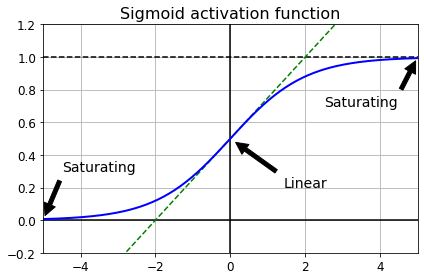

In [85]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), 'b-', linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha='center')
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha='center')
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha='center')
plt.grid(True)
plt.title('Sigmoid activation function', fontsize=16)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Glorot and He Initialization

In their paper, Glorot and Bengio propose a way to significantly alleviate the unstable gradients problem. They point out that we need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. We don’t want the signal to die out, nor do we want it to explode and saturate. For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction (please check out the paper if you are interested in the mathematical details). It is actually not possible to guarantee both unless the layer has an equal number of inputs and neurons (these numbers are called the fan-in and fan-out of the layer), but Glorot and Bengio proposed a good compromise that has proven to work very well in practice: the connection weights of each layer must be initialized randomly as described in Equation 11-1, where $fan_{avg} = (fan_{in} + fan_{out}/2$. This initialization strategy is called ***Xavier initialization or Glorot initialization***, after the paper’s first author.

***Equation 11-1. Glorot initialization (when using the logistic activation function)*** <br>
Normal distribution with mean $0$ and variance $\sigma^2 = \frac{1}{fan_{avg}}$  
Or a uniform distribution between $-r$ and $+r$, with $r = \sqrt{\frac{3}{fan_{avg}}}$

If you replace $fan_{avg}$ with $fan_{in}$ in Equation 11-1, you get an initialization strategy that Yann LeCun proposed in the 1990s. He called it *LeCun initialization*. Genevieve Orr and Klaus-Robert Müller even recommended it in their 1998 book *Neural Networks*: *Tricks of the Trade* (Springer). LeCun initialization is equivalent to Glorot initialization when $fan_{in} = fan_{out}$. It took over a decade for researchers to realize how important this trick is. Using Glorot initialization can speed up training considerably, and it is one of the tricks that led to the success of Deep Learning.

Some papers have provided similar strategies for different activation functions. These strategies differ only by the scale of the variance and whether they use $fan_{avg}$ or $fan_{in}$, as shown in Table 11-1 (for the uniform distribution, just compute $r = \sqrt{3\sigma^2}$). The initialization strategy for the ReLU activation function (and its variants, including the ELU activation described shortly) is sometimes called `He initialization`, after the paper’s first author. The SELU activation function will be explained later in this chapter. It should be used with LeCun initialization (preferably with a normal distribution, as we will see).

![Initialization parameters of each type of activation function](images/training_DNN/initialization_parameters_activation_func.png)

In [65]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

By default, Keras uses ***Glorot*** initialization with a uniform distribution. When creating a layer, you can change this to ***He*** initialization by setting ***kernel_initializer='he_uniform'*** or ***kernel_initializer='he_normal'*** like this:
``` python
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')
```

If you want ***He*** initialization with a uniform distribution but based on ***fan***$_{avg}$ rather than ***fan***$_{in}$, you can use the ***VarianceScaling*** initializer like this:
``` python
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation='sigmoid', kernel_initializer=he_avg_init)
```

In [66]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [67]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions

One of the insights in the 2010 paper by Glorot and Bengio was that the problems with unstable gradients were in part due to a poor choice of activation function. Until then most people had assumed that if Mother Nature had chosen to use roughly sigmoid activation functions in biological neurons, they must be an excellent choice. But it turns out that other activation functions behave much better in deep neural networks—in particular, ***`the ReLU activation function, mostly because it does not saturate for positive values (and because it is fast to compute)`***

**Unfortunately, the ReLU activation function is not perfect. It suffers from a problem known as the dying ReLUs: during training, some neurons effectively “die,” meaning they stop outputting anything other than 0. In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.**

***To solve this problem, you may want to use a variant of the ReLU function, such as the `leaky ReLU`. This function is defined as $LeakyReLU_α(z) = max(αz, z)$ (see Figure 11-2). The hyperparameter $α$ defines how much the function `“leaks”`: it is the slope of the function for $z < 0$ and is typically set to $0.01$. `This small slope ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up.` A [2015 paper](https://homl.info/49) `compared several variants of the ReLU activation function, and one of its conclusions was that the leaky variants always outperformed the strict ReLU activation function.` In fact, setting $α = 0.2$ (a huge leak) seemed to result in better performance than $α = 0.01$ (a small leak). The paper also evaluated the `randomized leaky ReLU (RReLU)`, where $α$ is picked randomly in a given range during training and is fixed to an average value during testing. `RReLU also performed fairly well and seemed to act as a regularizer (reducing the risk of overfitting the training set).` Finally, the paper evaluated the `parametric leaky ReLU (PReLU)`, where $α$ is authorized to be learned during training (instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter). `PReLU was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.`***

In [86]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [91]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

### ReLU

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [103]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 4ms/step - loss: 1.8506 - accuracy: 0.4323 - val_loss: 1.0055 - val_accuracy: 0.7110
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.9354 - accuracy: 0.7177 - val_loss: 0.7534 - val_accuracy: 0.7652
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7437 - accuracy: 0.7588 - val_loss: 0.6670 - val_accuracy: 0.7880
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6584 - accuracy: 0.7847 - val_loss: 0.6064 - val_accuracy: 0.8044
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6166 - accuracy: 0.7983 - val_loss: 0.5686 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5751 - accuracy: 0.8113 - val_loss: 0.5419 - val_accuracy: 0.8258
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5471 - accuracy: 0.8201 - val_loss: 0.5200 - val_accuracy

In [101]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal', activation='relu'),
    keras.layers.Dense(100, kernel_initializer='he_normal', activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 3ms/step - loss: 1.6975 - accuracy: 0.4971 - val_loss: 0.9259 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8709 - accuracy: 0.7245 - val_loss: 0.7308 - val_accuracy: 0.7626
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7213 - accuracy: 0.7620 - val_loss: 0.6566 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6449 - accuracy: 0.7881 - val_loss: 0.6005 - val_accuracy: 0.8044
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6078 - accuracy: 0.8003 - val_loss: 0.5657 - val_accuracy: 0.8182
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5693 - accuracy: 0.8119 - val_loss: 0.5407 - val_accuracy: 0.8236
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5428 - accuracy: 0.8195 - val_loss: 0.5197 - val_accuracy

In [104]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_16 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_17 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### Leaky ReLU

In [68]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


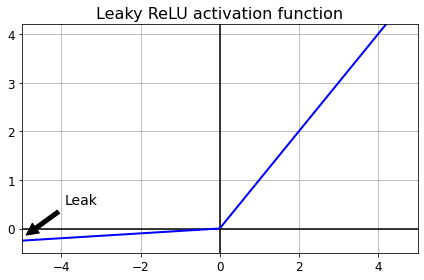

In [84]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.plot(z, leaky_relu(z, 0.05), 'b-', linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha='center')
plt.grid(True)
plt.title('Leaky ReLU activation function', fontsize=16)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

To use the leaky ReLU activation function, create a ***`LeakyReLU`*** layer and add it to your model just after the layer you want to apply it to:

```python
model = keras.models.Sequential([
    [...]
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.2),
    [...]
])
```

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [93]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation='softmax')
])

In [94]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               235500    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
________________________________________________

In [95]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [96]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 1.6314 - accuracy: 0.5054 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8416 - accuracy: 0.7246 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7053 - accuracy: 0.7637 - val_loss: 0.6427 - val_accuracy: 0.7902
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6325 - accuracy: 0.7907 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5992 - accuracy: 0.8019 - val_loss: 0.5582 - val_accuracy: 0.8202
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5624 - accuracy: 0.8142 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5379 - accuracy: 0.8218 - val_loss: 0.5157 - val_accuracy:

### Now let's try PReLU:

For ***PReLU***, replace ***LeakyRelu(alpha=0.2)*** with ***`PReLU()`***. There is currently no official implementation of RReLU in Keras, but you can fairly easily implement your own (to learn how to do that, see the exercises at the end of Chapter 12).

In [97]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation='softmax')
])

In [98]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 300)               235500    
_________________________________________________________________
p_re_lu (PReLU)              (None, 300)               300       
_________________________________________________________________
dense_10 (Dense)             (None, 100)               30100     
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 100)               100       
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
Total params: 267,010
Trainable params: 267,010
Non-trainable params: 0
________________________________________________

In [99]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [100]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 1.6969 - accuracy: 0.4974 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8706 - accuracy: 0.7247 - val_loss: 0.7305 - val_accuracy: 0.7632
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7211 - accuracy: 0.7620 - val_loss: 0.6565 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6448 - accuracy: 0.7880 - val_loss: 0.6003 - val_accuracy: 0.8046
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6078 - accuracy: 0.8003 - val_loss: 0.5656 - val_accuracy: 0.8180
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5693 - accuracy: 0.8117 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5428 - accuracy: 0.8193 - val_loss: 0.5196 - val_accuracy:

### ELU

Last but not least, a [2015 paper](https://homl.info/50) by Djork-Arné Clevert et al. proposed a new activation function called the **`exponential linear unit (ELU)`** that outperformed all the ReLU variants in the authors’ experiments: `training time was reduced, and the neural network performed better on the test set.` Figure 11-3(below) graphs the function, and Equation 11-2 shows its definition.

*Equation 11-2. ELU activation function*

**ELU**$_\alpha (z) = \alpha(exp(z)-1$ **`if`** $z < 0$, $z$ **`if`** $z>= 0$

In [37]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure ELU_plot


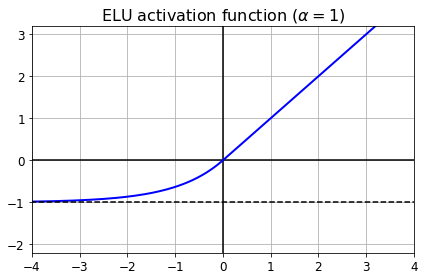

In [38]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.plot(z, elu(z), 'b-', linewidth=2)
plt.plot([-5, 5], [-1, -1], 'k--')

plt.grid(True)
plt.title(r'ELU activation function ($\alpha=1$)', fontsize=16)
plt.axis([-4, 4, -2.2, 3.2])

save_fig("ELU_plot")
plt.show()

The ELU activation function looks a lot like the ReLU function, with a few major differences:
* It takes on negative values when $z < 0$, which allows the unit to have an average output closer to $0$ and helps alleviate the vanishing gradients problem. The hyperparameter $\alpha$ defines the value that the ELU function approaches when z is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter.

* It has a nonzero gradient for $z < 0$, which avoids the dead neurons problem.

* If $\alpha$ is equal to $1$ then the function is smooth everywhere, including around $z = 0$, which helps speed up Gradient Descent since it does not bounce as much to the left and right of $z = 0$.

`The main drawback of the ELU activation function is that it is slower to compute than the ReLU function and its variants (due to the use of the exponential function). Its faster convergence rate during training compensates for that slow computation, but still, at test time an ELU network will be slower than a ReLU network.`

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [26]:
keras.layers.Dense(10, activation="elu")

### SELU

Then, a [2017 paper](https://homl.info/selu) by Günter Klambauer et al. introduced the `Scaled ELU (SELU)` activation function: as its name suggests, it is a scaled variant of the ELU activation function. The authors showed that if you build a neural network composed exclusively of a stack of dense layers, and if all hidden layers use the SELU activation function, then the network will self-normalize: the output of each layer will tend to `preserve a mean of 0 and standard deviation of 1 during training`, which solves the vanishing/exploding gradients problem. As a result, the SELU activation function often significantly outperforms other activation functions for such neural nets (especially deep ones). There are, however, a few conditions for self-normalization to happen (see the paper for the mathematical justification):

* The input features must be standardized (mean 0 and standard deviation 1).

* Every hidden layer’s weights must be initialized with LeCun normal initialization. In Keras, this means setting `kernel_initializer="lecun_normal"`.

* `The network’s architecture must be sequential. Unfortunately, if you try to use SELU in nonsequential architectures, such as recurrent networks (see Chapter 15) or networks with skip connections (i.e., connections that skip layers, such as in Wide & Deep nets), self-normalization will not be guaranteed, so SELU will not necessarily outperform other activation functions.`

* `The paper only guarantees self-normalization if all layers are dense, but some researchers have noted that the SELU activation function can improve performance in convolutional neural nets as well (see Chapter 14).`

For ***SELU*** activation, set ***`activation="selu"`*** and ***`kernel_initializer="lecun_normal"`*** when creating a layer:

```python
keras.layers.Dense(10, activation='selu', 
                  kernel_initializer='lecun_normal')
```

In [27]:
keras.layers.Dense(10, activation='selu', 
                  kernel_initializer='lecun_normal')

> ***`In Colab notebook`***

> This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, `this activation function outperforms the other activation functions very significantly for such neural nets`, so you should really try it out. `Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use` ℓ<sub>1</sub> `or` ℓ<sub>2</sub> `regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize).` ***However, in practice it works quite well with sequential CNNs.*** `If you break self-normalization, SELU will not necessarily outperform other activation functions.`

In [4]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [30]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


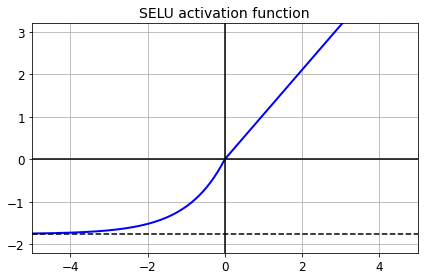

In [39]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the ***SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:***

In [40]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [41]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

In [43]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [44]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

***Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:***

In [4]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [46]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 35s 18ms/step - loss: 1.5515 - accuracy: 0.4109 - val_loss: 1.0267 - val_accuracy: 0.6228
Epoch 2/5
1719/1719 [==============================] - 30s 17ms/step - loss: 0.8707 - accuracy: 0.6588 - val_loss: 0.7100 - val_accuracy: 0.7198
Epoch 3/5
1719/1719 [==============================] - 30s 18ms/step - loss: 0.7340 - accuracy: 0.7023 - val_loss: 0.6401 - val_accuracy: 0.7432
Epoch 4/5
1719/1719 [==============================] - 30s 17ms/step - loss: 0.6358 - accuracy: 0.7548 - val_loss: 0.5612 - val_accuracy: 0.8010
Epoch 5/5
1719/1719 [==============================] - 30s 17ms/step - loss: 0.5677 - accuracy: 0.7932 - val_loss: 0.5534 - val_accuracy: 0.8102


***Now look at what happens if we try to use the ReLU activation function instead:***

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu",
                             kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu",
                                 kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [48]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [49]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 33s 16ms/step - loss: 2.0794 - accuracy: 0.1857 - val_loss: 1.2931 - val_accuracy: 0.4426
Epoch 2/5
1719/1719 [==============================] - 28s 16ms/step - loss: 1.2462 - accuracy: 0.4646 - val_loss: 0.8471 - val_accuracy: 0.6764
Epoch 3/5
1719/1719 [==============================] - 27s 16ms/step - loss: 1.1994 - accuracy: 0.5252 - val_loss: 0.8759 - val_accuracy: 0.6806
Epoch 4/5
1719/1719 [==============================] - 26s 15ms/step - loss: 0.9132 - accuracy: 0.6373 - val_loss: 0.7527 - val_accuracy: 0.7110
Epoch 5/5
1719/1719 [==============================] - 28s 16ms/step - loss: 0.7970 - accuracy: 0.6848 - val_loss: 0.7049 - val_accuracy: 0.7310


***`Not great at all, we suffered from the vanishing/exploding gradients problem.`***

## TIP

> So, which activation function should you use for the hidden layers of your deep neural networks? Although your mileage will vary, in general **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">SELU > ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic</span>**. If the network’s architecture prevents it from self-normalizing, then **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">ELU</span>** may perform better than **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">SELU</span>** (since **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">SELU</span>** is not smooth at $z = 0$). If you care a lot about runtime latency, then you may prefer **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">leaky ReLU</span>**. If you don’t want to tweak yet another hyperparameter, you may use the default $α$ values used by Keras (e.g., $0.3$ for **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">leaky ReLU</span>**). If you have spare time and computing power, you can use cross-validation to evaluate other activation functions, such as **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">RReLU</span>** if your network is overfitting or **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">PReLU</span>** if you have a huge training set. That said, because **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">ReLU</span>** is the most used activation function (by far), many libraries and hardware accelerators provide **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">ReLU</span>**-specific optimizations; therefore, if speed is your priority, **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">ReLU</span>** might still be the best choice.

### Batch Normalization

Although using _He_ initialization along with *ELU* (or any variant of *ReLU*) can significantly reduce the danger of the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.

In a [2015 paper](https://homl.info/51), Sergey Ioffe and Christian Szegedy proposed a technique called `Batch Normalization (BN) that addresses these problems. The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs. In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set (e.g., using a StandardScaler); the BN layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).`

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the mean and standard deviation of the input over the current mini-batch (hence the name “Batch Normalization”). The whole operation is summarized step by step in Equation 11-3.

![Batch Normalization algorithm](images/training_DNN/batch_normalization_algo.png)

In this algorithm:

* $μ_B$ is the vector of input means, evaluated over the whole mini-batch $B$ (it contains one mean per input).

* $σ_B$ is the vector of input standard deviations, also evaluated over the whole mini-batch (it contains one standard deviation per input).

* $m_B$ is the number of instances in the mini-batch.

* $\hat{x}^{(i)}$ is the vector of zero-centered and normalized inputs for instance $i$.

* $γ$ is the output scale parameter vector for the layer (it contains one scale parameter per input).

* $⊗$ represents element-wise multiplication (each input is multiplied by its corresponding output scale parameter).

* $β$ is the output shift (offset) parameter vector for the layer (it contains one offset parameter per input). Each input is offset by its corresponding shift parameter.

* $ε$ is a tiny number that avoids division by zero (typically $10^{–5}$). This is called a `smoothing` term.

* $z^{(i)}$ is the output of the BN operation. It is a rescaled and shifted version of the inputs.

So during training, BN standardizes its inputs, then rescales and offsets them. Good! What about at test time? Well, it’s not that simple. Indeed, we may need to make predictions for individual instances rather than for batches of instances: in this case, we will have no way to compute each input’s mean and standard deviation. Moreover, even if we do have a batch of instances, it may be too small, or the instances may not be independent and identically distributed, so computing statistics over the batch instances would be unreliable. `One solution could be to wait until the end of training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the BN layer. These “final” input means and standard deviations could then be used instead of the batch input means and standard deviations when making predictions. However, most implementations of Batch Normalization estimate these final statistics during training by using a moving average of the layer’s input means and standard deviations.` This is what Keras does automatically when you use the BatchNormalization layer. To sum up, four parameter vectors are learned in each batch-normalized layer: $\gamma$ (the output scale vector) and $\beta$ (the output offset vector) are learned through regular backpropagation, and μ (the final input mean vector) and $\sigma$ (the final input standard deviation vector) are estimated using an exponential moving average. Note that $\mu$ and $\sigma$ are estimated during training, but they are used only after training (to replace the batch input means and standard deviations in Equation 11-3).

Ioffe and Szegedy demonstrated that Batch Normalization considerably improved all the deep neural networks they experimented with, leading to a huge improvement in the ImageNet classification task (ImageNet is a large database of images classified into many classes, commonly used to evaluate computer vision systems). The vanishing gradients problem was strongly reduced, to the point that they could use saturating activation functions such as the tanh and even the logistic activation function. The networks were also much less sensitive to the weight initialization. The authors were able to use much larger learning rates, significantly speeding up the learning process. Specifically, they note that:

> ***Applied to a state-of-the-art image classification model, Batch Normalization achieves the same accuracy with 14 times fewer training steps, and beats the original model by a significant margin. […] Using an ensemble of batch-normalized networks, we improve upon the best published result on ImageNet classification: reaching 4.9% top-5 validation error (and 4.8% test error), exceeding the accuracy of human raters.***

`Finally, like a gift that keeps on giving, Batch Normalization acts like a regularizer, reducing the need for other regularization techniques (such as dropout, described later in this chapter).`

Batch Normalization does, however, add some complexity to the model (although it can remove the need for normalizing the input data, as we discussed earlier). Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer. Fortunately, it’s often possible to fuse the BN layer with the previous layer, after training, thereby avoiding the runtime penalty. This is done by updating the previous layer’s weights and biases so that it directly produces outputs of the appropriate scale and offset. For example, if the previous layer computes $XW + b$, then the BN layer will compute $γ⊗(XW + b – μ)/σ + β$ (ignoring the smoothing term $ε$ in the denominator). If we define $W′ = γ⊗W/σ$ and $b′ = γ⊗(b – μ)/σ + β$, the equation simplifies to $XW′ + b′$. So if we replace the previous layer’s weights and biases ($W$ and $b$) with the updated weights and biases ($W′$ and $b′$), we can get rid of the BN layer (TFLite’s optimizer does this automatically; see Chapter 19).

### NOTE

> You may find that training is rather slow, because each epoch takes much more time when you use Batch Normalization. This is usually counterbalanced by the fact that convergence is much faster with BN, so it will take fewer epochs to reach the same performance. All in all, `wall time` will usually be shorter (this is the time measured by the clock on your wall).

### Implementing Batch Normalization with Keras

As with most things with Keras, implementing Batch Normalization is simple and intuitive. Just add a BatchNormalization layer before or after each hidden layer’s activation function, and optionally add a BN layer as well as the first layer in your model. For example, this model applies BN after every hidden layer and as the first layer in the model (after flattening the input images):

In [56]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

That’s all! **`In this tiny example with just two hidden layers, it’s unlikely that Batch Normalization will have a very positive impact; but for deeper networks it can make a tremendous difference.`**

Let’s display the model summary:

In [57]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_208 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
dense_209 (Dense)            (None, 300)               90300     
_________________________________________________________________
batch_normalization_5 (Batch (None, 300)               1200      
_________________________________________________________________
dense_210 (Dense)            (None, 10)               

As you can see, each BN layer adds four parameters per input: $γ$, $β$, $μ$, and $σ$ (for example, the first BN layer adds $3,136$ parameters, which is $4 × 784$). The last two parameters, $μ$ and $σ$, are the moving averages; they are not affected by backpropagation, so Keras calls them “non-trainable” (if you count the total number of BN parameters, $3,136 + 1,200 + 400$, and divide by $2$, you get $2,368$, which is the total number of non-trainable parameters in this model).

Let’s look at the parameters of the first BN layer. Two are trainable (by backpropagation), and two are not:

In [58]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization_3/gamma:0', True),
 ('batch_normalization_3/beta:0', True),
 ('batch_normalization_3/moving_mean:0', False),
 ('batch_normalization_3/moving_variance:0', False)]

Now when you create a BN layer in Keras, it also creates **`two operations` that will be called by Keras at each iteration during training. These operations will update the moving averages.** Since we are using the TensorFlow backend, these operations are TensorFlow operations (we will discuss TF operations in Chapter 12):

In [59]:
# bn1.updates #deprecated

In [63]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [61]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 6ms/step - loss: 1.0867 - accuracy: 0.6377 - val_loss: 0.5053 - val_accuracy: 0.8268
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5625 - accuracy: 0.8011 - val_loss: 0.4401 - val_accuracy: 0.8492
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5007 - accuracy: 0.8237 - val_loss: 0.4117 - val_accuracy: 0.8588
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4586 - accuracy: 0.8373 - val_loss: 0.3937 - val_accuracy: 0.8612
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4427 - accuracy: 0.8436 - val_loss: 0.3822 - val_accuracy: 0.8648
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4132 - accuracy: 0.8521 - val_loss: 0.3730 - val_accuracy: 0.8704
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4003 - accuracy: 0.8578 - val_loss: 0.3646 - val_ac

**Extra**<br>
***Testing different activation function and batch normalization layer:***

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
keras.layers.BatchNormalization(),
model.add(keras.layers.Dense(300, activation="relu", 
                             kernel_initializer='he_normal'))
keras.layers.BatchNormalization(), # commented when testing on without BN layer

for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", 
                                kernel_initializer='he_normal'))
    keras.layers.BatchNormalization(), # commented when testing on without BN layer
model.add(keras.layers.Dense(10, activation="softmax"))

In [6]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [69]:
# with batch normalization layer + when kernel_initializer not given
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 30s 16ms/step - loss: 2.3026 - accuracy: 0.1004 - val_loss: 2.3026 - val_accuracy: 0.0914
Epoch 2/5
1719/1719 [==============================] - 28s 16ms/step - loss: 2.3026 - accuracy: 0.0992 - val_loss: 2.3027 - val_accuracy: 0.0914
Epoch 3/5
1719/1719 [==============================] - 28s 16ms/step - loss: 2.3026 - accuracy: 0.0985 - val_loss: 2.3027 - val_accuracy: 0.0914
Epoch 4/5
1719/1719 [==============================] - 27s 16ms/step - loss: 2.3026 - accuracy: 0.1030 - val_loss: 2.3027 - val_accuracy: 0.0914
Epoch 5/5
1719/1719 [==============================] - 28s 16ms/step - loss: 2.3026 - accuracy: 0.1008 - val_loss: 2.3027 - val_accuracy: 0.0914


In [79]:
# with batch normalization layer with kernel_initializer='he_normal'
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 33s 17ms/step - loss: 2.0873 - accuracy: 0.2029 - val_loss: 1.7030 - val_accuracy: 0.3480
Epoch 2/5
1719/1719 [==============================] - 31s 18ms/step - loss: 1.7249 - accuracy: 0.3299 - val_loss: 1.3305 - val_accuracy: 0.4888
Epoch 3/5
1719/1719 [==============================] - 27s 15ms/step - loss: 1.3244 - accuracy: 0.4778 - val_loss: 1.3690 - val_accuracy: 0.4374
Epoch 4/5
1719/1719 [==============================] - 27s 16ms/step - loss: 1.0806 - accuracy: 0.5655 - val_loss: 0.8215 - val_accuracy: 0.6950
Epoch 5/5
1719/1719 [==============================] - 28s 16ms/step - loss: 1.0400 - accuracy: 0.5943 - val_loss: 1.2865 - val_accuracy: 0.4812


In [76]:
# without batch normalization layer expect after input layer  with kernel_initializer='he_normal'
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 31s 16ms/step - loss: 2.0873 - accuracy: 0.2029 - val_loss: 1.7030 - val_accuracy: 0.3480
Epoch 2/5
1719/1719 [==============================] - 28s 16ms/step - loss: 1.7249 - accuracy: 0.3299 - val_loss: 1.3305 - val_accuracy: 0.4888
Epoch 3/5
1719/1719 [==============================] - 28s 16ms/step - loss: 1.3244 - accuracy: 0.4778 - val_loss: 1.3690 - val_accuracy: 0.4374
Epoch 4/5
1719/1719 [==============================] - 28s 16ms/step - loss: 1.0806 - accuracy: 0.5655 - val_loss: 0.8215 - val_accuracy: 0.6950
Epoch 5/5
1719/1719 [==============================] - 28s 16ms/step - loss: 1.0400 - accuracy: 0.5943 - val_loss: 1.2865 - val_accuracy: 0.4812


Testing on SELU activation function

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [45]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [46]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 35s 18ms/step - loss: 1.5515 - accuracy: 0.4109 - val_loss: 1.0267 - val_accuracy: 0.6228
Epoch 2/5
1719/1719 [==============================] - 30s 17ms/step - loss: 0.8707 - accuracy: 0.6588 - val_loss: 0.7100 - val_accuracy: 0.7198
Epoch 3/5
1719/1719 [==============================] - 30s 18ms/step - loss: 0.7340 - accuracy: 0.7023 - val_loss: 0.6401 - val_accuracy: 0.7432
Epoch 4/5
1719/1719 [==============================] - 30s 17ms/step - loss: 0.6358 - accuracy: 0.7548 - val_loss: 0.5612 - val_accuracy: 0.8010
Epoch 5/5
1719/1719 [==============================] - 30s 17ms/step - loss: 0.5677 - accuracy: 0.7932 - val_loss: 0.5534 - val_accuracy: 0.8102


`The authors of the BN paper argued in favor of adding the BN layers before the activation functions, rather than after (as we just did). There is some debate about this, as which is preferable seems to depend on the task—you can experiment with this too to see which option works best on your dataset. To add the BN layers before the activation functions, you must remove the activation function from the hidden layers and add them as separate layers after the BN layers. Moreover, since a Batch Normalization layer includes one offset parameter per input, you can remove the bias term from the previous layer (just pass use_bias=False when creating it):`

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [16]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 17s 7ms/step - loss: 1.2672 - accuracy: 0.5757 - val_loss: 0.6053 - val_accuracy: 0.8032
Epoch 2/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.6409 - accuracy: 0.7833 - val_loss: 0.5076 - val_accuracy: 0.8298
Epoch 3/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.5577 - accuracy: 0.8090 - val_loss: 0.4632 - val_accuracy: 0.8456
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5063 - accuracy: 0.8237 - val_loss: 0.4370 - val_accuracy: 0.8486
Epoch 5/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4859 - accuracy: 0.8297 - val_loss: 0.4195 - val_accuracy: 0.8548
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4584 - accuracy: 0.8389 - val_loss: 0.4054 - val_accuracy: 0.8590
Epoch 7/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4426 - accuracy: 0.8447 - val_loss: 0.3949 - val_ac

### Gradient Clipping

Another popular technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold. This is called [Gradient Clipping](https://homl.info/52). ***`This technique is most often used in recurrent neural networks, as Batch Normalization is tricky to use in RNNs`***, as we will see in Chapter 15. `For other types of networks, BN is usually sufficient.`

In Keras, implementing Gradient Clipping is just a matter of setting the clipvalue or clipnorm argument when creating an optimizer, like this:

In [6]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss='mse', optimizer=optimizer)

In [7]:
optimizer

This optimizer will clip every component of the gradient vector to a value between $–1.0$ and $1.0$. This means that all the partial derivatives of the loss (with regard to each and every trainable parameter) will be clipped between $–1.0$ and $1.0$. The threshold is a hyperparameter you can tune. Note that it may change the orientation of the gradient vector. For instance, if the original gradient vector is $[0.9, 100.0]$, it points mostly in the direction of the second axis; but once you clip it by value, you get $[0.9, 1.0]$, which points roughly in the diagonal between the two axes. In practice, this approach works well. If you want to ensure that Gradient Clipping does not change the direction of the gradient vector, you should clip by norm by setting ***`clipnorm` instead of `clipvalue`***. This will clip the whole gradient if its $ℓ_2$ norm is greater than the threshold you picked. For example, if you set $clipnorm=1.0$, then the vector $[0.9, 100.0]$ will be clipped to $[0.00899964, 0.9999595]$, preserving its orientation but almost eliminating the first component. If you observe that the gradients explode during training (you can track the size of the gradients using TensorBoard), you may want to try both clipping by value and clipping by norm, with different thresholds, and see which option performs best on the validation set.

In [8]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

## Reusing Pretrained Layers

It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle (we will discuss how to find them in Chapter 14), then reuse the lower layers of this network. This technique is called ***transfer learning***. It will not only speed up training considerably, but also require significantly less training data.

Suppose you have access to a DNN that was trained to classify pictures into 100 different categories, including animals, plants, vehicles, and everyday objects. You now want to train a DNN to classify specific types of vehicles. These tasks are very similar, even partly overlapping, so you should try to reuse parts of the first network (see Figure 11-4).

![Reusing pretrained layers](images/training_DNN/reusing_pretrained_layers.png)

## NOTE
> If the input pictures of your task don't have the same size as the ones used in the original task, you will usually have to add a preprocessing step to resize them to the size expected by the original model. More generally, transfer learning will work best when the inputs have similar low-level features.

The output layer of the original model should usually be replaced because it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.
<br><br>
Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. You want to find the right number of layers to reuse.

### TIP
> `The more similar the tasks are, the more layers you want to reuse (starting with the lower layers). For very similar tasks, try keeping all the hidden layers and just replacing hte output layer.`

`Try freezing all the reused layers first (i.e., make their weights non-trainable so that Gradient Descent won’t modify them), then train your model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. The more training data you have, the more layers you can unfreeze. It is also useful to reduce the learning rate when you unfreeze reused layers: this will avoid wrecking their fine-tuned weights.`
<br><br>
`If you still cannot get good performance, and you have little training data, try dropping the top hidden layer(s) and freezing all the remaining hidden layers again. You can iterate until you find the right number of layers to reuse. If you have plenty of training data, you may try replacing the top hidden layers instead of dropping them, and even adding more hidden layers.`

### Transfer Learning with Keras

Let’s look at an example. Suppose the Fashion MNIST dataset only contained eight classes—for example, all the classes except for sandal and shirt. Someone built and trained a Keras model on that set and got reasonably good performance (>90% accuracy). Let’s call this model A. You now want to tackle a different task: you have images of sandals and shirts, and you want to train a binary classifier (positive=shirt, negative=sandal). Your dataset is quite small; you only have 200 labeled images. When you train a new model for this task (let’s call it model B) with the same architecture as model A, it performs reasonably well (97.2% accuracy). But since it’s a much easier task (there are just two classes), you were hoping for more. While drinking your morning coffee, you realize that your task is quite similar to task A, so perhaps transfer learning can help? Let’s find out!

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [6]:
def split_dataset(X, y):
    y_5_or_y_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_y_6]
    y_A[y_A > 6] -= 2 # class indicies 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_y_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_y_6], y_A), (X[y_5_or_y_6], y_B))

In [7]:
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [8]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((55000, 28, 28), (55000,), (5000, 28, 28), (5000,), (10000, 28, 28), (10000,))

In [9]:
X_train_A.shape, y_train_A.shape, X_valid_A.shape, y_valid_A.shape, X_test_A.shape, y_test_A.shape

((43986, 28, 28), (43986,), (4014, 28, 28), (4014,), (8000, 28, 28), (8000,))

In [10]:
X_train_B.shape, y_train_B.shape, X_valid_B.shape, y_valid_B.shape, X_test_B.shape, y_test_B.shape

((200, 28, 28), (200,), (986, 28, 28), (986,), (2000, 28, 28), (2000,))

In [43]:
tf.random.set_seed(42)
np.random.seed(42)

model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation='selu'))
model_A.add(keras.layers.Dense(8, activation='softmax'))

In [44]:
model_A.compile(loss='sparse_categorical_crossentropy',
               optimizer=keras.optimizers.SGD(lr=1e-3),
               metrics=['accuracy'])

In [45]:
history = model_A.fit(X_train_A, y_train_A, validation_data=(X_valid_A, y_valid_A), epochs=20)

Epoch 1/20
1375/1375 [==============================] - 7s 5ms/step - loss: 0.9249 - accuracy: 0.6994 - val_loss: 0.3896 - val_accuracy: 0.8662
Epoch 2/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3651 - accuracy: 0.8745 - val_loss: 0.3288 - val_accuracy: 0.8827
Epoch 3/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3182 - accuracy: 0.8896 - val_loss: 0.3014 - val_accuracy: 0.8986
Epoch 4/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3049 - accuracy: 0.8953 - val_loss: 0.2896 - val_accuracy: 0.9011
Epoch 5/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2804 - accuracy: 0.9028 - val_loss: 0.2775 - val_accuracy: 0.9061
Epoch 6/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2701 - accuracy: 0.9078 - val_loss: 0.2736 - val_accuracy: 0.9066
Epoch 7/20
1375/1375 [==============================] - 6s 5ms/step - loss: 0.2626 - accuracy: 0.9092 - val_loss: 0.2718 - val_accuracy:

In [46]:
model_A.save('model_A.h5')

In [59]:
tf.random.set_seed(42)
np.random.seed(42)

model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation='selu'))
model_B.add(keras.layers.Dense(1, activation='sigmoid'))

In [60]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [61]:
history = model_B.fit(X_train_B, y_train_B, epochs=20, validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 48ms/step - loss: 0.5977 - accuracy: 0.7285 - val_loss: 0.5192 - val_accuracy: 0.7911
Epoch 2/20
7/7 [==============================] - 0s 32ms/step - loss: 0.4927 - accuracy: 0.7552 - val_loss: 0.4383 - val_accuracy: 0.8408
Epoch 3/20
7/7 [==============================] - 0s 72ms/step - loss: 0.3959 - accuracy: 0.8526 - val_loss: 0.3794 - val_accuracy: 0.8773
Epoch 4/20
7/7 [==============================] - 0s 25ms/step - loss: 0.3442 - accuracy: 0.8824 - val_loss: 0.3344 - val_accuracy: 0.9026
Epoch 5/20
7/7 [==============================] - 0s 25ms/step - loss: 0.2879 - accuracy: 0.9228 - val_loss: 0.2994 - val_accuracy: 0.9168
Epoch 6/20
7/7 [==============================] - 0s 26ms/step - loss: 0.2637 - accuracy: 0.9520 - val_loss: 0.2712 - val_accuracy: 0.9290
Epoch 7/20
7/7 [==============================] - 0s 21ms/step - loss: 0.2263 - accuracy: 0.9714 - val_loss: 0.2482 - val_accuracy: 0.9341
Epoch 8/20
7/7 [===========

In [21]:
model_B.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

First, you need to load model A and create a new model based on that model’s layers. 

In [47]:
model_A = keras.models.load_model("model_A.h5")

Let’s reuse all the layers except for the output layer:

In [48]:
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [49]:
model_B_on_A.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_20 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_21 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_22 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_23 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                

**`Note that model_A and model_B_on_A now share some layers. When you train model_B_on_A, it will also affect model_A. If you want to avoid that, you need to clone model_A before you reuse its layers. To do this, you clone model A’s architecture with clone.model(), then copy its weights (since clone_model() does not clone the weights):`**

In [50]:
model_A_clone = keras.models.clone_model(model_A)

In [51]:
model_A_clone.set_weights(model_A.get_weights())

In [52]:
model_A_clone.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_20 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_21 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_22 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_23 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_24 (Dense)             (None, 8)                

Now you could train model_B_on_A for task B, but since the new output layer was initialized randomly it will make large errors (at least during the first few epochs), so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. To do this, set every layer’s trainable attribute to False and compile the model:

In [53]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False
    
model_B_on_A.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.SGD(lr=1e-3), 
                     metrics=['accuracy'])

## **NOTE**
> `You must always compile your model after you freeze or unfreeze layers.`

`Now you can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights:`

In [54]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 42ms/step - loss: 0.1999 - accuracy: 0.9533 - val_loss: 0.2160 - val_accuracy: 0.9665
Epoch 2/4
7/7 [==============================] - 0s 21ms/step - loss: 0.1983 - accuracy: 0.9604 - val_loss: 0.2105 - val_accuracy: 0.9665
Epoch 3/4
7/7 [==============================] - 0s 22ms/step - loss: 0.1815 - accuracy: 0.9674 - val_loss: 0.2052 - val_accuracy: 0.9716
Epoch 4/4
7/7 [==============================] - 0s 22ms/step - loss: 0.1877 - accuracy: 0.9606 - val_loss: 0.2004 - val_accuracy: 0.9736


In [55]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

# optimizer = keras.optimizers.SGD(lr=1e-4) # the default lr is 1e-2 and previously we used 1e-3
optimizer = keras.optimizers.SGD(lr=1e-3) # the default lr is 1e-2 and previously we used 1e-3
model_B_on_A.compile(loss='binary_crossentropy', 
                    optimizer=optimizer, 
                    metrics=['accuracy'])

In [56]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 1s 43ms/step - loss: 0.1733 - accuracy: 0.9533 - val_loss: 0.1753 - val_accuracy: 0.9757
Epoch 2/16
7/7 [==============================] - 0s 24ms/step - loss: 0.1519 - accuracy: 0.9668 - val_loss: 0.1567 - val_accuracy: 0.9807
Epoch 3/16
7/7 [==============================] - 0s 22ms/step - loss: 0.1255 - accuracy: 0.9826 - val_loss: 0.1417 - val_accuracy: 0.9838
Epoch 4/16
7/7 [==============================] - 0s 23ms/step - loss: 0.1187 - accuracy: 0.9821 - val_loss: 0.1302 - val_accuracy: 0.9838
Epoch 5/16
7/7 [==============================] - 0s 22ms/step - loss: 0.0990 - accuracy: 0.9908 - val_loss: 0.1206 - val_accuracy: 0.9848
Epoch 6/16
7/7 [==============================] - 0s 22ms/step - loss: 0.1069 - accuracy: 0.9823 - val_loss: 0.1123 - val_accuracy: 0.9868
Epoch 7/16
7/7 [==============================] - 0s 21ms/step - loss: 0.0935 - accuracy: 0.9842 - val_loss: 0.1055 - val_accuracy: 0.9888
Epoch 8/16
7/7 [===========

So, what’s the final verdict?

In [62]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.1234 - accuracy: 0.9840


[0.12341559678316116, 0.984000027179718]

In [58]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0653 - accuracy: 0.9945


[0.06529685109853745, 0.9944999814033508]

Well, this model’s test accuracy is 99.45%, which means that transfer learning reduced the error rate from 1.6% down to almost 0.55%! That’s a factor of 2.9!

In [63]:
(100 - 98.4) / (100 - 99.45)

2.9090909090909136

***`Are you convinced? You shouldn’t be: I cheated! I tried many configurations until I found one that demonstrated a strong improvement. If you try to change the classes or the random seed, you will see that the improvement generally drops, or even vanishes or reverses. What I did is called “torturing the data until it confesses.” When a paper just looks too positive, you should be suspicious: perhaps the flashy new technique does not actually help much (in fact, it may even degrade performance), but the authors tried many variants and reported only the best results (which may be due to sheer luck), without mentioning how many failures they encountered on the way. Most of the time, this is not malicious at all, but it is part of the reason so many results in science can never be reproduced.`*** <br>

***`Why did I cheat? It turns out that transfer learning does not work very well with small dense networks, presumably because small networks learn few patterns, and dense networks learn very specific patterns, which are unlikely to be useful in other tasks. Transfer learning works best with deep convolutional neural networks, which tend to learn feature detectors that are much more general (especially in the lower layers).`*** `We will revisit transfer learning in Chapter 14, using the techniques we just discussed (and this time there will be no cheating, I promise!).`

### Unsupervised Pretraining

Suppose you want to tackle a complex task for which you don’t have much labeled training data, but unfortunately you cannot find a model trained on a similar task. Don’t lose hope! **First, you should try to gather more labeled training data, but if you can’t, you may still be able to perform `unsupervised pretraining`** (see Figure 11-5). Indeed, it is often cheap to gather unlabeled training examples, but expensive to label them. If you can gather plenty of unlabeled training data, you can try to use it to train an unsupervised model, such as an autoencoder or a generative adversarial network (see Chapter 17). *Then you can reuse the lower layers of the autoencoder or the lower layers of the GAN’s discriminator*, add the output layer for your task on top, and fine-tune the final network using supervised learning (i.e., with the labeled training examples).

It is this technique that Geoffrey Hinton and his team used in 2006 and which led to the revival of neural networks and the success of Deep Learning. Until 2010, unsupervised pretraining—typically with restricted Boltzmann machines (RBMs; see Appendix E)—was the norm for deep nets, and only after the vanishing gradients problem was alleviated did it become much more common to train DNNs purely using supervised learning. Unsupervised pretraining (today typically using autoencoders or GANs rather than RBMs) is still a good option when you have a complex task to solve, no similar model you can reuse, and little labeled training data but plenty of unlabeled training data.

Note that in the early days of Deep Learning it was difficult to train deep models, so people would use a technique called **greedy layer-wise pretraining** (depicted in Figure 11-5). They would first train an unsupervised model with a single layer, typically an RBM, then they would freeze that layer and add another one on top of it, then train the model again (effectively just training the new layer), then freeze the new layer and add another layer on top of it, train the model again, and so on. Nowadays, things are much simpler: people generally train the full unsupervised model in one shot (i.e., in Figure 11-5, just start directly at step three) and use autoencoders or GANs rather than RBMs.

![In unsupervised training, a model is trained on the unlabeled data (or on all the data) using an unsupervised learning technique, then it is fine-tuned for the final task on the labeled data using a supervised learning technique; the unsupervised part may train one layer at a time as shown here, or it may train the full model directly](images/training_DNN/unsupervised_training.png)

### Pretraining on an Auxiliary Task

If you do not have much labeled training data, one last option is to train a first neural network on an auxiliary task for which you can easily obtain or generate labeled training data, then reuse the lower layers of that network for your actual task. The first neural network’s lower layers will learn feature detectors that will likely be reusable by the second neural network.

For example, if you want to build a system to recognize faces, you may only have a few pictures of each individual—clearly not enough to train a good classifier. Gathering hundreds of pictures of each person would not be practical. You could, however, gather a lot of pictures of random people on the web and train a first neural network to detect whether or not two different pictures feature the same person. Such a network would learn good feature detectors for faces, so reusing its lower layers would allow you to train a good face classifier that uses little training data

For natural language processing (NLP) applications, you can download a corpus of millions of text documents and automatically generate labeled data from it. For example, you could randomly mask out some words and train a model to predict what the missing words are (e.g., it should predict that the missing word in the sentence “What ___ you saying?” is probably “are” or “were”). If you can train a model to reach good performance on this task, then it will already know quite a lot about language, and you can certainly reuse it for your actual task and fine-tune it on your labeled data (we will discuss more pretraining tasks in Chapter 15).

### **NOTE**

> **`Self-supervised learning`** is when you automatically generate the labels from the data itself, then you train a model on the resulting "labelled" dataset using supervised learning techniques. Since this approach requires no human labelling whatsoever, it is best classified as a form of unsupervised learning.

## Faster Optimizers 

Training a very large deep neural network can be painfully slow. So far we have seen four ways to speed up training (and reach a better solution): **applying a good initialization strategy for the connection weights, using a good activation function, using Batch Normalization, and reusing parts of a pretrained network (possibly built on an auxiliary task or using unsupervised learning).** Another huge **speed boost** comes from using a faster optimizer than the regular Gradient Descent optimizer. In this section we will present the most popular algorithms: `momentum optimization, Nesterov Accelerated Gradient, AdaGrad, RMSProp, and finally Adam and Nadam optimization.`

### Momentum Optimization

Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance). This is the very simple idea behind momentum optimization, [proposed by Boris Polyak in 1964](https://homl.info/54). In contrast, regular Gradient Descent will simply take small, regular steps down the slope, so the algorithm will take much more time to reach the bottom.

Recall that Gradient Descent updates the weights $\theta$ by directly subtracting the gradient of the cost function $J(\theta)$ with regard to the weights $(\nabla_\theta J(\theta))$ multiplied by the learning rate $\eta$. The equation is: $\theta ← \theta - \eta \nabla_\theta J(\theta)$. It does not care about what the earlier gradients were. *If the local gradient is tiny, it goes very slowly.*

**Momentum optimization cares a great deal about what previous gradients were**: at each iteration, it subtracts the local gradient from the momentum vector m (multiplied by the learning rate $\eta$), and it updates the weights by adding this momentum vector (see Equation 11-4). `In other words, the gradient is used for acceleration, not for speed.` To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter $\beta$, **`called the momentum, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.`**

> Equation 11-4. Momentum algorithm
> 1. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $m ← \beta m - \eta \nabla_\theta J(\theta)$
> 2. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\theta ← \theta + m$

You can easily verify that if the gradient remains constant, the terminal velocity (i.e., the maximum size of the weight updates) is equal to that gradient multiplied by the learning rate $\eta$ multiplied by $\frac{1}{1 - \beta}$ (ignoring the sign). For example, if $\beta = 0.9$, then the terminal velocity is equal to $10$ times the gradient times the learning rate, so momentum optimization ends up going $10$ times faster than Gradient Descent! This allows momentum optimization to escape from plateaus much faster than Gradient Descent. We saw in Chapter 4 that when the inputs have very different scales, the cost function will look like an elongated bowl (see Figure 4-7). Gradient Descent goes down the steep slope quite fast, but then it takes a very long time to go down the valley. In contrast, `momentum optimization will roll down the valley faster and faster until it reaches the bottom (the optimum).` **`In deep neural networks that don’t use Batch Normalization, the upper layers will often end up having inputs with very different scales, so using momentum optimization helps a lot. It can also help roll past local optima.`**

### NOTE

> Due to the momentum, the optimizer may overshoot a bit, then come back, overshoot again, and oscillate like this many times before stabilizing at the minimum. **This is one of the reasons it’s good to have a bit of friction in the system: it gets rid of these oscillations and thus speeds up convergence.**

Implementing momentum optimization in Keras is a no-brainer: just use the `SGD` optimizer and set its momentum hyperparameter, then lie back and profit!

In [3]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

In [4]:
optimizer

The one drawback of momentum optimization is that it adds yet another hyperparameter to tune. However, the momentum value of 0.9 usually works well in practice and almost always goes faster than regular Gradient Descent.

### Nestrov Accelerated Gradient

One small variant to momentum optimization, [proposed by Yurii Nesterov in 1983](https://homl.info/55), is ***almost always faster than vanilla momentum optimization***. The `Nesterov Accelerated Gradient (NAG)` method, also known as `Nesterov momentum optimization`, measures the gradient of the cost function not at the local position $\theta$ but slightly ahead in the direction of the momentum, at $\theta + \beta m$ (see Equation 11-5).

> Equation 11-5. Nesterov Accelerated Gradient algorithm
> 1. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $m ← \beta m - \eta \nabla_\theta J(\theta + \beta m)$
> 2. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\theta ← \theta + m$

This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position, as you can see in Figure 11-6 (where $\nabla_1$ represents the gradient of the cost function measured at the starting point $\theta$, and $\nabla_2$ represents the gradient at the point located at $\theta + \beta m$).

As you can see, the ***Nesterov update ends up slightly closer to the optimum.*** After a while, these small improvements add up and NAG ends up being significantly faster than regular momentum optimization. **`Moreover, note that when the momentum pushes the weights across a valley,` $\nabla_1$ `continues to push farther across the valley,` `while` $\nabla_2$ `pushes back toward the bottom of the valley. This helps reduce oscillations and thus NAG converges faster.`**

NAG is generally faster than regular momentum optimization. To use it, simply set $nesterov=True$ when creating the SGD optimizer:

In [5]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

In [6]:
optimizer

![Regular versus Nesterov momentum optimization: the former applies the gradients computed before the momentum step, while the latter applies the gradients computed after](images/training_DNN/Regular_versus_Nesterov_momentum_optimization.png)

### AdaGrad

Consider the elongated bowl problem again: Gradient Descent starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goes down to the bottom of the valley. It would be nice if the algorithm could correct its direction earlier to point a bit more toward the global optimum. The [AdaGrad algorithm](https://homl.info/56) achieves this correction by scaling down the gradient vector along the steepest dimensions (see Equation 11-6).

> Equation 11-6. AdaGrad algorithm
> 1. &emsp; $s ← s + \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta)$
> 2. &emsp; $\theta ← \theta - \eta \nabla_\theta J(\theta) \oslash \sqrt{s + \epsilon}$

The first step accumulates the square of the gradients into the vector $s$ (recall that the $\otimes$ symbol represents the element-wise multiplication). This vectorized form is equivalent to computing $s_i$ &#8592; $s_i$ $+$ $(\partial J(\theta)$ $/$ $\partial \theta_i)^2$ for each element $s_i$ of the vector $\mathbf s$; in other words, each $s_i$ accumulates the squares of the partial derivative of the cost function with regard to parameter $θ_i$. If the cost function is steep along the $i^{th}$ dimension, then $s_i$ will get larger and larger at each iteration.

The second step is almost identical to Gradient Descent, but with one big difference: the gradient vector is scaled down by a factor of $\sqrt{s + \epsilon}$ (the $\oslash$ symbol represents the element-wise division, and $\epsilon$ is a smoothing term to avoid division by zero, typically set to $10^{–10}$). This vectorized form is equivalent to simultaneously computing $\theta_i$ &#8592; $\theta_i$ $-$ $\eta \partial J(\theta)$ $/$ $\partial \theta_i$ $/$ $\sqrt{s_i + \epsilon}$ for all parameters $\theta_i$.

**In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. `This is called an adaptive learning rate.` It helps point the resulting updates more directly toward the global optimum (see Figure 11-7). One additional benefit is that it requires much less tuning of the learning rate hyperparameter $\eta$.**

![AdaGrad versus Gradient Descent: the former can correct its direction earlier to point to the optimum](images/training_DNN/AdaGrad_versus_Gradient_Descent.png)

**AdaGrad frequently performs well for simple quadratic problems, `but it often stops too early when training neural networks.` The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum. So even though Keras has an Adagrad optimizer, `you should not use it to train deep neural networks` (it may be efficient for simpler tasks such as Linear Regression, though). Still, understanding AdaGrad is helpful to grasp the other adaptive learning rate optimizers.**

In [7]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

In [8]:
optimizer

### RMSProp

As we’ve seen, AdaGrad runs the risk of slowing down a bit too fast and never converging to the global optimum. The RMSProp algorithm fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training). It does so by using exponential decay in the first step (see Equation 11-7).

> Equation 11-7. RMSProp algorithm
> 1. &emsp; $s ← \beta s + (1- \beta) \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta)$
> 2. &emsp; $\theta ← \theta - \eta \nabla_\theta J(\theta) \oslash \sqrt{s + \epsilon}$

The decay rate $\beta$ is typically set to $0.9$. Yes, it is once again a new hyperparameter, but this default value often works well, so you may not need to tune it at all.

As you might expect, Keras has an *RMSProp* optimizer:

In [9]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

In [10]:
optimizer

Except on very simple problems, this optimizer almost always performs much better than AdaGrad. In fact, `it was the preferred optimization algorithm of many researchers until Adam optimization came around.`

### Adam and Nadam Optimization

[Adam](https://homl.info/59), which stands for **`adaptive moment estimation`, combines the ideas of momentum optimization and RMSProp: just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients** (see Equation 11-8).

> Equation 11-8. Adam algorithm
> 1. &emsp; $\mathbf m ← \beta_1 \mathbf m - (1 - \beta_1)\nabla_\theta J(\theta)$
> 2. &emsp; $\mathbf {s} ← \beta_2 \mathbf s + (1- \beta_2) \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta)$
> 3. &emsp; $\mathbf {\hat m} ← \frac {\mathbf m}{1 - \beta_1^T}$
> 4. &emsp; $\mathbf {\hat s} ← \frac {\mathbf {s}}{1 - \beta_2^T}$
> 5. &emsp; $\theta ← \theta + \eta \mathbf {\hat m} \oslash \sqrt{\mathbf {\hat s} + \epsilon}$

In this equation, $t$ represents the iteration number (starting at 1).

If you just look at steps 1, 2, and 5, you will notice Adam's close similarity to both momentum optimization and RMSProp. the only difference is that step 1 computes an exponentially decaying average rather than an exponentially decaying sum, but these are actually equivalent except for a constant factor (the decaying average is just $1 - \beta_1$ times the decaying sum). Steps 3 and 4 are somewhat of a technical detail: since $\mathbf m$ and $\mathbf s$ are initialized at $0$, they will be biased toward $0$ at the beginning of training, so these two steps will help boost $\mathbf m$ and $\mathbf s$ at the beginning of training.

The momentum decay hyperparameter $\beta_1$ is typically initialized to $0.9$, while the scaling decay hyperparameter $\beta_2$ is often initialized to $0.999$. As earlier, the smoothing term $\epsilon$ is usually initialized to a tiny number such as $10^{–7}$. These are the default values for the Adam class (to be precise, epsilon defaults to None, which tells Keras to use `keras.backend.epsilon()`, which defaults to $10^{–7}$; you can change it using `keras.backend.set_epsilon()`). Here is how to create an Adam optimizer using Keras:

In [11]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [12]:
optimizer

Since Adam is an adaptive learning rate algorithm (like AdaGrad and RMSProp), it requires less tuning of the learning rate hyperparameter $\eta$. You can often use the default value $\eta = 0.001$, making Adam even easier to use than Gradient Descent.

### TIP

> If you are starting to feel overwhelmed by all these different techniques and are wondering how to choose the right ones for your task, don't worry: some practical guidelines are provided at the end of this chapter.

Finally, two variants of Adam are worth mentioning:

***`AdaMax`***

> Notice that in step 2 of Equation 11-8, Adam accumulates the squares of the gradients in $\mathbf s$ (with a greater weight for more recent weights). In step 5, if we ignore $\epsilon$ and steps 3 and 4 (which are technical details anyway), Adam scales down the parameter updates by the square root of $\mathbf s$. In short, Adam scales down the parameter updates by the $l_2$ norm of the time-decayed gradients (recall that the $l_2$ norm is the square root of the sum of squares). AdaMax, introduced in the same paper as Adam, replaces the $l_2$ norm with the $l_∞$ norm (a fancy way of saying the max). Specifically, it replaces step 2 in Equation 11-8 with $\mathbf s ← $ max $(\beta_2 s, \nabla_\theta J(\theta))$, it drops step 4, and in step 5 it scales down the gradient updates by a factor of $\mathbf s$, which is just the max of the time-decayed gradients. **`In practice, this can make AdaMax more stable than Adam, but it really depends on the dataset, and in general Adam performs better. So, this is just one more optimizer you can try if you experience problems with Adam on some task.`**

In [13]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

In [14]:
optimizer

**`Nadam`**

> Nadam optimization is Adam optimization plus the Nesterov trick, so it will often converge slightly faster than Adam. In [his report introducing this technique](https://homl.info/nadam), the researcher Timothy Dozat compares many different optimizers on various tasks and ***`finds that Nadam generally outperforms Adam but is sometimes outperformed by RMSProp.`***

In [15]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [16]:
optimizer

### **WARNING**

> ***`Adaptive optimization methods (including RMSProp, Adam, and Nadam optimization) are often great, converging fast to a good solution. However, a` [2017 paper](https://homl.info/60) `by Ashia C. Wilson et al. showed that they can lead to solutions that generalize poorly on some datasets. So when you are disappointed by your model’s performance, try using plain Nesterov Accelerated Gradient instead: your dataset may just be allergic to adaptive gradients. Also check out the latest research, because it’s moving fast.`***

All the optimization techniques discussed so far only rely on the _first-order partial derivatives (Jacobians)_. The optimization literature also contains amazing algorithms based on the _second-order partial derivatives_ (the _Hessians_, which are the partial derivatives of the Jacobians). Unfortunately, these algorithms are very hard to apply to deep neural networks because there are n2 Hessians per output (where n is the number of parameters), as opposed to just n Jacobians per output. Since DNNs typically have tens of thousands of parameters, the second-order optimization algorithms often don’t even fit in memory, and even when they do, computing the Hessians is just too slow.

## **TRAINING SPARSE MODELS**

> **`All the optimization algorithms just presented produce dense models, meaning that most parameters will be nonzero. If you need a blazingly fast model at runtime, or if you need it to take up less memory, you may prefer to end up with a sparse model instead.` <br> <br>
> One easy way to achieve this is to train the model as usual, then get rid of the tiny weights (set them to zero). Note that this will typically not lead to a very sparse model, and it may degrade the model’s performance. <br> <br>
> A better option is to apply strong $l_1$ regularization during training (we will see how later in this chapter), as it pushes the optimizer to zero out as many weights as it can (as discussed in “Lasso Regression” in Chapter 4). <br> <br>
> If these techniques remain insufficient, check out the [TensorFlow Model Optimization Toolkit (TF-MOT)](https://homl.info/tfmot), which provides a pruning API capable of iteratively removing connections during training based on their magnitude.**

Table 11-2 compares all the optimizers we’ve discussed so far (* is bad, ** is average, and *** is good).

![Optimizer comparison](images/training_DNN/optimizer_comparison.png)

### **Learning Rate Scheduling**

Finding a good learning rate is very important. If you set it much too high, training may diverge (as we discussed in “Gradient Descent”). If you set it too low, training will eventually converge to the optimum, but it will take a very long time. If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never really settling down. If you have a limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution (see Figure 11-8).

![Learning curves for various learning rates $\eta$](images/training_DNN/learning_curves_for_various_learning_rates.png)

As we discussed in Chapter 10, you can find a good learning rate by training the model for a few hundred iterations, exponentially increasing the learning rate from a very small value to a very large value, and then looking at the learning curve and picking a learning rate slightly lower than the one at which the learning curve starts shooting back up. You can then reinitialize your model and train it with that learning rate.

But you can do better than a constant learning rate: ***if you start with a large learning rate and then reduce it once training stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate. There are many different strategies to reduce the learning rate during training. It can also be beneficial to start with a low learning rate, increase it, then drop it again. These strategies are called `learning schedules`*** (we briefly introduced this concept in Chapter 4). These are the most commonly used learning schedules:

**`Power scheduling`**

> Set the learning rate to a function of the iteration number $t$: $\eta(t)$ $=$ $\eta_0$ $/$ $(1$ $+$ $t/s)^c$. The initial learning rate $\eta_0$, the power $c$ (typically set to $1$), and the steps $s$ are hyperparameters. The learning rate drops at each step. After $s$ steps, it is down to $\eta_0$ $/$ $2$. After $s$ more steps, it is down to $\eta_0$ $/$ $3$, then it goes down to $\eta_0$ $/$ $4$, then $\eta_0$ $/$ $5$, and so on. As you can see, this schedule first drops quickly, then more and more slowly. Of course, power scheduling requires tuning $\eta_0$ and $s$ (and possibly $c$).

> `lr = lr0 / (1 + steps / s)**c`
> * Keras uses `c = 1` and `s = 1 / decay`

In [3]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [4]:
optimizer

In [5]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [9]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid), epochs=n_epochs)

Epoch 1/25
1719/1719 [==============================] - 13s 6ms/step - loss: 0.6012 - accuracy: 0.7886 - val_loss: 0.4093 - val_accuracy: 0.8596
Epoch 2/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3852 - accuracy: 0.8648 - val_loss: 0.3735 - val_accuracy: 0.8716
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3463 - accuracy: 0.8763 - val_loss: 0.3551 - val_accuracy: 0.8762
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3256 - accuracy: 0.8852 - val_loss: 0.3528 - val_accuracy: 0.8780
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3061 - accuracy: 0.8930 - val_loss: 0.3464 - val_accuracy: 0.8792
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2972 - accuracy: 0.8927 - val_loss: 0.3423 - val_accuracy: 0.8822
Epoch 7/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2866 - accuracy: 0.8991 - val_loss: 0.3315 - val_accuracy

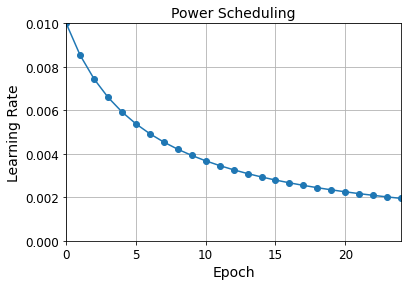

In [23]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train_scaled) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs, 'o-')
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

**`Exponential scheduling`**

> Set the learning rate to $\eta(t)$ $=$ $\eta_0$ $0.1^{t/s}$. The learning rate will gradually drop by a factor of 10 every s steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every s steps.

> `lr = lr0 * 0.1**(epoch / s)`

In [5]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [6]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [7]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Nadam(), metrics=['accuracy'])

In [9]:
n_epochs = 25

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn, verbose=1)
history = model.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid), epochs=n_epochs, callbacks=[lr_scheduler])

Epoch 1/25

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
1719/1719 [==============================] - 14s 8ms/step - loss: 1.7034 - accuracy: 0.4071 - val_loss: 1.3224 - val_accuracy: 0.4710
Epoch 2/25

Epoch 00002: LearningRateScheduler reducing learning rate to 0.008912509381337455.
1719/1719 [==============================] - 13s 8ms/step - loss: 1.3026 - accuracy: 0.4751 - val_loss: 1.2261 - val_accuracy: 0.5258
Epoch 3/25

Epoch 00003: LearningRateScheduler reducing learning rate to 0.007943282347242816.
1719/1719 [==============================] - 13s 8ms/step - loss: 1.2129 - accuracy: 0.5165 - val_loss: 1.1948 - val_accuracy: 0.5520
Epoch 4/25

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0070794578438413795.
1719/1719 [==============================] - 13s 8ms/step - loss: 1.1289 - accuracy: 0.5399 - val_loss: 1.1393 - val_accuracy: 0.5606
Epoch 5/25

Epoch 00005: LearningRateScheduler reducing learning rate to 0.006309573444801933.
1719

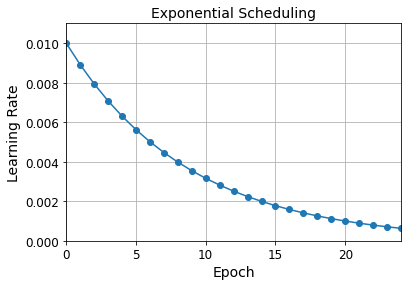

In [13]:
plt.plot(history.epoch, history.history['lr'], 'o-')
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The Schedule function can take the current learning rate as a second argument:

In [14]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

**`If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:`**

In [17]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s
    
    def on_batch_begin(self, batch, logs=None):
        # Note: that the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [18]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

lr0 = 0.01
model.compile(optimizer=keras.optimizers.Nadam(lr=lr0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
n_epochs = 25

s = 20 * len(X_train) // 32 # no. of steps in 20 epochs (batch_size 32)
exp_decay = ExponentialDecay(s=s)
history = model.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid), epochs=n_epochs, callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 17s 9ms/step - loss: 1.1117 - accuracy: 0.7369 - val_loss: 0.7126 - val_accuracy: 0.8212
Epoch 2/25
1719/1719 [==============================] - 15s 9ms/step - loss: 0.7106 - accuracy: 0.7943 - val_loss: 0.7155 - val_accuracy: 0.7956
Epoch 3/25
1719/1719 [==============================] - 15s 8ms/step - loss: 0.6159 - accuracy: 0.8172 - val_loss: 0.6416 - val_accuracy: 0.8258
Epoch 4/25
1719/1719 [==============================] - 15s 9ms/step - loss: 0.5264 - accuracy: 0.8387 - val_loss: 0.5194 - val_accuracy: 0.8320
Epoch 5/25
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4691 - accuracy: 0.8510 - val_loss: 0.6287 - val_accuracy: 0.8312
Epoch 6/25
1719/1719 [==============================] - 15s 8ms/step - loss: 0.4416 - accuracy: 0.8591 - val_loss: 0.4797 - val_accuracy: 0.8514
Epoch 7/25
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4030 - accuracy: 0.8700 - val_loss: 0.4745 - val_ac

In [24]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps/s)

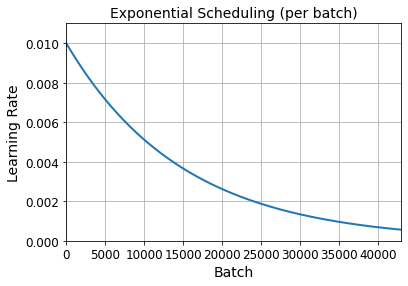

In [28]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

**`Piecewise constant scheduling`**

> Use a constant learning rate for a number of epochs (e.g., $\eta_0$ $=$ $0.1$ for $5$ epochs), then a smaller learning rate for another number of epochs (e.g., $\eta_0 = 0.001$ for $50$ epochs), and so on. Although this solution can work very well, it requires fiddling around to figure out the right sequence of learning rates and how long to use each of them.

In [49]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [50]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [51]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn, verbose=1)

In [53]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(optimizer=keras.optimizers.Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [54]:
n_epochs = 25

history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_valid_scaled, y_valid), 
                    epochs=n_epochs, 
                    callbacks=[lr_scheduler])

Epoch 1/25

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
1719/1719 [==============================] - 16s 8ms/step - loss: 1.0835 - accuracy: 0.7315 - val_loss: 0.8893 - val_accuracy: 0.6592
Epoch 2/25

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
1719/1719 [==============================] - 13s 8ms/step - loss: 0.8970 - accuracy: 0.7333 - val_loss: 0.8117 - val_accuracy: 0.7402
Epoch 3/25

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
1719/1719 [==============================] - 13s 8ms/step - loss: 0.7718 - accuracy: 0.7573 - val_loss: 1.3021 - val_accuracy: 0.6368
Epoch 4/25

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
1719/1719 [==============================] - 13s 8ms/step - loss: 0.8885 - accuracy: 0.7238 - val_loss: 0.9946 - val_accuracy: 0.6994
Epoch 5/25

Epoch 00005: LearningRateScheduler reducing learning rate to 0.01.
1719/1719 [==============================] - 14s 8ms/step - loss: 0.8

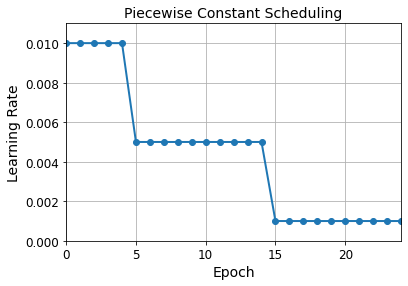

In [74]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-", linewidth=2)
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

**`Performance scheduling`**

> Measure the validation error every $N$ steps (just like for early stopping), and reduce the learning rate by a factor of $\lambda$ when the error stops dropping.